# Urban Sound Classification Using PyTorch Vision Transformer


> **Hello! 👋**
>
> I'm excited to share this project with you, and I hope you enjoy it as much as I enjoyed working on it! 😊 I've put a lot of effort into this project, and I'm always eager to improve my skills.
>
> If you have any feedback or suggestions, please don't hesitate to share them. Your input helps me make my projects even better. 🤗

---

In this project, I've implemented the Vision Transformer (ViT) architecture to tackle the task of classifying urban sounds. The ViT model is a cutting-edge transformer-based architecture known for achieving outstanding results in image classification tasks.

My primary aim is to replicate the ViT computer vision model described in the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929) and adapt it for classifying urban sounds. I've applied this model to the [UrbanSound8K](https://www.kaggle.com/datasets/chrisfilo/urbansound8k) dataset.

## Libraries

To accomplish this project, I've utilized several libraries:

- PyTorch
- Torchaudio
- Torchinfo
- NumPy
- Pandas
- Scikit-learn
- Seaborn
- Matplotlib

These libraries serve various purposes, including:

- Loading and preprocessing audio data.
- Creating, training and assessing the ViT model's performance.
- Visualizing the model's outcomes.

## 1. UrbanSound8k Dataset
The UrbanSound8k dataset is a collection of 8732 labeled sound excerpts, each lasting no longer than 4 seconds, capturing various urban auditory environments. The dataset consists of 10 distinct classes:

- Air conditioner,
- Car horn,
- Children playing,
- Dog bark, drilling,
- Engine idling,
- Gunshot,
- Jackhammer,
- Siren, and
- Street music.

The UrbanSound8k dataset is available on [Kaggle](https://www.kaggle.com/datasets/chrisfilo/urbansound8k).  However, due to its large size (~6GB), it can take a significant amount of time to download from Kaggle. To address this, I have downloaded the dataset and made it available on Google Drive.

In [44]:
import gdown
import os
import zipfile

def download_and_unzip_dataset(gdrive_url, destination):
    """
    Download a dataset from a Google Drive URL, unzip it, and delete the zip file.

    Args:
      gdrive_url (str): The Google Drive URL of the dataset.
      destination (str): The directory where the downloaded dataset will be saved.

    Return: None
      Prints out if the dataset was successfully downloaded, unzipped, and cleaned.
    """

    # Create the output directory if it doesn't exist
    os.makedirs(destination, exist_ok=True)

    # Check if the dataset has already been downloaded and unzipped
    if os.path.exists(os.path.join(destination, 'UrbanSound8K.csv')):
        print("[INFO] Dataset already exists, skipping download.")
    else:

        # Download the dataset
        output_path = os.path.join(destination, 'UrbanSound8k.zip')
        print("[INFO] Downloading dataset...")
        gdown.download(gdrive_url, output_path, quiet=True)

        # Check if the dataset was successfully downloaded
        if os.path.exists(output_path):
            # Unzip the dataset
            print("[INFO] Unzipping 'UrbanSound8k.zip' file...")
            with zipfile.ZipFile(output_path, 'r') as zip_ref:
                zip_ref.extractall(destination)

            # Remove .zip file
            print("[INFO] Deleting 'UrbanSound8k.zip' file...")
            os.remove(output_path)


gdrive_url = "https://drive.google.com/uc?id=1LxBYwmQqNcEvIAdronE6vc0dZuP7yg-r"  # Replace with your actual Google Drive URL
destination = "./data"  # Keep this folder to work with

download_and_unzip_dataset(gdrive_url, destination)

[INFO] Dataset already exists, skipping download.


### 1.1 Audio and Metadata Files

All the sound files are pre-sorted into ten folds (folders named from 'fold1' to 'fold10').

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided. Here is an example.

In [45]:
import pandas as pd

ANNOTATIONS_FILE = "./data/UrbanSound8K.csv"
df = pd.read_csv(ANNOTATIONS_FILE)

In [46]:
df.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
2134,151977-0-0-4.wav,151977,2.466587,6.466587,1,1,0,air_conditioner
626,111048-6-0-0.wav,111048,0.000000,1.314579,1,6,6,gun_shot
7152,62837-7-1-53.wav,62837,288.206708,292.206708,1,3,7,jackhammer
6205,34952-8-0-4.wav,34952,2.000000,6.000000,2,6,8,siren
4632,187378-3-0-30.wav,187378,15.000000,19.000000,1,9,3,dog_bark


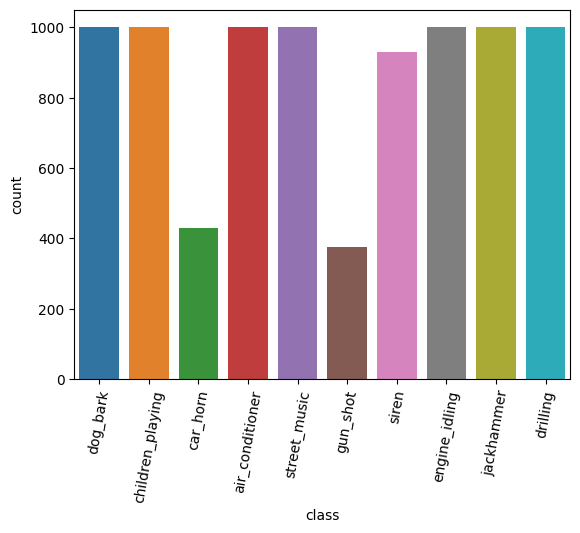

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df,x='class')
plt.xticks(rotation=80);

These are the 10 classes in the UrbanSound8k dataset. Where car horn and gun shot classes are underrepresented in the dataset. This underrepresentation can make it difficult for deep learning models to learn to classify these sounds accurately.

### 1.2 Generate train, validation and test splits
Split the dataset into train, validation, and test sets using a stratified split. This ensures that the distribution of classes is the same in each of the three sets.

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataframe(df:pd.DataFrame,
                    train_ratio:float=0.8,
                    valid_ratio:float=0.1,
                    random_state=42):
    """
    Split a pandas DataFrame into train, validation, and test sets.

    Args:
        df (pd.DataFrame): The DataFrame to be split.
        train_ratio (float): The ratio for the train set. Default is 0.8.
        valid_ratio (float): The ratio for the validation set. Default is 0.1.
        random_state (int or None): Random seed for reproducibility. Default is None.

    Returns:
        pd.DataFrame: Train set
        pd.DataFrame: Validation set
        pd.DataFrame: Test set
    """
    test_ratio = 1-train_ratio-valid_ratio
    df_train, df_temp = train_test_split(df, test_size=1-train_ratio, random_state=random_state)
    df_valid, df_test = train_test_split(df_temp, test_size=1-valid_ratio/(valid_ratio+test_ratio), random_state=random_state)

    return df_train, df_valid, df_test


# Split the DataFrame
df_train, df_valid, df_test = split_dataframe(df=df, train_ratio=0.8, valid_ratio=0.1, random_state=42)

# Print the sizes of the splits
print("Train set size:", len(df_train))
print("Validation set size:", len(df_valid))
print("Test set size:", len(df_test))


Train set size: 6985
Validation set size: 873
Test set size: 874


### Importing PyTorch and setting up device-agnostic code

The first step is to import torch module, it provides the basic functionality for working with tensors and GPUs in PyTorch.

In [49]:
import torch

# Check for the availability of a GPU and set the default device
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1.3 Create custom Datasets. UrbanSoundDataset Class

This class is designed to create a custom dataset for working with audio data from the UrbanSound8k dataset. It takes raw audio files, preprocesses them, and returns the audio samples with uniform characteristics that are suitable for machine learning tasks.

The dataset's internal workings involve the following steps:

1. **Get the audio sample path and label**. The path to the audio file and its corresponding label are retrieved.
2. **Load the audio sample and get its sample rate**. The audio sample is loaded and its sample rate is obtained.
3. **Resample the audio sample to the target sample rate**. If the sample rate of the audio sample is different from the target sample rate, then it is resampled to the target sample rate.
4. **Mix down the audio sample to mono if it is stereo**. If the audio sample is in stereo, then it is mixed down to mono.
5. **Cut the audio sample to the desired length**. The audio sample is trimmed to the desired length.
6. **Right pad the audio sample to the desired length**. If the audio sample is shorter than the desired length, then it is right padded with zeros to the desired length.
7. **Apply the transformation to the audio sample**. The transformation function is applied to the audio sample.
8. **Normalize the mel spectrograms if necessary**. If the mel spectrograms need to be normalized, then they are normalized.


In [50]:
import os

from torch.utils.data import Dataset
import pandas
import pandas as pd
import torchaudio


class UrbanSoundDataset(Dataset):
    """
    A Pytorch dataset for preprocess UrbanSound audio data.

    Args:
        annotations_df (pandas.DataFrame): DataFrame containing audio file information.
        audio_dir (str): Directory path where audio files are stored.
        transformation (torchaudio.transforms): Audio transformation function to be applied.
        target_sample_rate (int): Target sample rates for audio resampling.
        num_samples (int): Number of samples to keep in each audio clip.
        device (torch.device): Device to be used.

    """
    def __init__(self,
                 annotations_df: pandas.DataFrame,
                 audio_dir: str,
                 transformation: torchaudio.transforms,
                 target_sample_rate: int,
                 num_samples: int,
                 normalize:bool=True,
                 device: torch.device = "cpu"):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.normalize = normalize

    def __len__(self):
        """
        Returns the number of audio samples in the dataset.

        Returns:
            int: Number of audio samples in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, index: int):
        """
        Loads and processes an audio sample along with its corresponding label.

        Args:
            index (int): Index of audio sample to load.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing audio sample and corresponding label.
        """
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)

        if self.normalize:
          signal = (signal - signal.min()) / (signal.max() - signal.min())

        return signal, label

    def _cut_if_necessary(self, signal: torch.Tensor):
        """
        Cuts the audio signal if the length is greater than `num_samples`.

        Args:
            signal (torch.Tensor): Audio signal.

        Returns:
            torch.Tensor: The cut audio if it was longer than `num_samples`.
        """
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal: torch.Tensor):
        """
        Right-pads the audio signal with zeros if its length is less than `num_samples`.

        Args:
            signal (torch.Tensor): Audio signal.

        Returns:
            torch.Tensor: The right-padded audio signal.
        """
        signal_length = signal.shape[1]
        if signal_length < self.num_samples:
            num_missing_samples = self.num_samples -signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal: torch.Tensor, sr: int):
        """
        Resamples the audio signal if its sample rate is different from `target_sample_rate`.

        Args:
            signal (torch.Tensor): Audio signal.
            sr (int): The current sample rate of the audio.

        Returns:
            torch.Tensor: The resampled audio signal if necessary, otherwise the original signal.
        """
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal: torch.Tensor):
        """
        Mixes down the audio signal to mono if it has multiple channels.

        Args:
            signal (torch.Tensor): Audio signal.

        Returns
            torch.Tensor: The mixed down audio signal if it had multiple channels,
            otherwise the original signal
        """
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index: int):
        """
        Retrieves the file path of the audio sample at the given index.

        Args:
            index (int): Index of audio sample in the DataFrame.

        Returns:
            str: File path of the audio sample.
        """
        fold = f"fold{self.annotations.iloc[index,5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index: int):
        """
        Retrieves the label of the audio sample at the given index.

        Args:
            index (int): Index of the audio sample in the DataFrame.

        Returns:
            str: The label of the audio sample.
        """
        return self.annotations.iloc[index, 6]

    def classes(self):
        """
        Returns the list of classes in the dataset.

        Returns:
            List[str]: List of classes in the dataset.
        """
        class_mapping = []
        for n in range(0,10):
            class_filter = self.annotations[self.annotations['classID']==n]
            class_mapping.append(class_filter['class'].unique().item())
        return class_mapping

The `FACTOR` variable controls the resolution and window size of the mel spectrograms. A value of `1` will create a 64x64 mel spectrogram, a value of `2` creates a 128x128, and so on. A higher value of FACTOR will create a higher-resolution spectrogram with a wider window. This will result in a more detailed representation of the sound signal, but it will also increase the computational cost of computing the spectrogram.

The `normalize` argument controls whether or not the mel spectrograms are normalized. In addition, normalizing the mel spectrograms can help to prevent the gradient of the parameters from diverging. If the gradient diverges, it means that the model is becoming unstable and it is not able to learn.

In [51]:
AUDIO_DIR = "./data"
FACTOR = 4
SAMPLE_RATE = 22050*FACTOR
NUM_SAMPLES = 22050*FACTOR

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                                       n_fft=1024*FACTOR,
                                                       hop_length=345,
                                                       n_mels=64*FACTOR)

us_dataset = UrbanSoundDataset(annotations_df=df_train,
                               audio_dir=AUDIO_DIR,
                               transformation=mel_spectrogram.to(device),
                               target_sample_rate=SAMPLE_RATE,
                               num_samples=NUM_SAMPLES,
                               normalize=True,
                               device=device)

We will need the name of the classes, so let's assign it to a variable.

In [52]:
# Define the class_names variable
class_names = us_dataset.classes()
class_names

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

### 1.4 Exploring the Dataset with Mel Spectrograms

The next step is to explore the dataset. This can be done by plotting the randomly six mel spectrograms from the dataset.

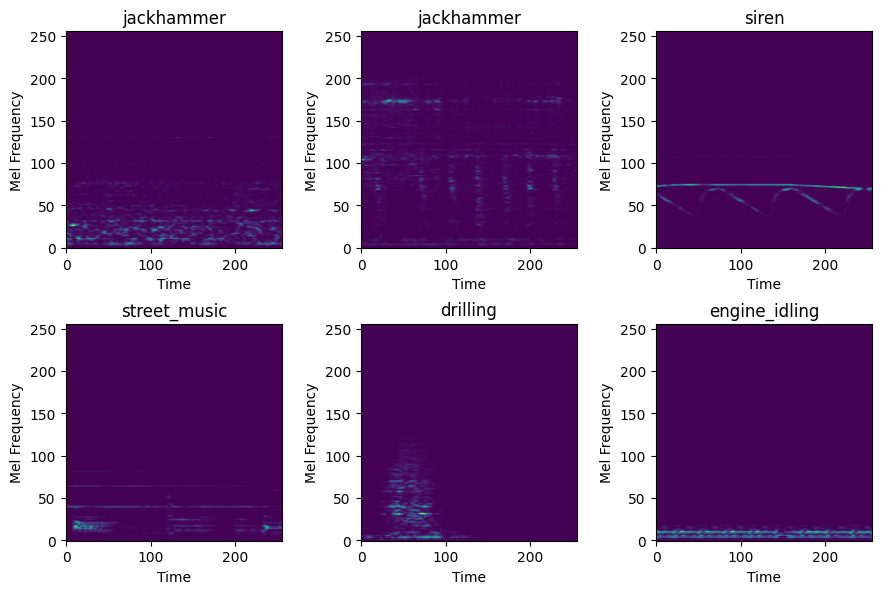

In [53]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5)

# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

# Assuming you want to plot the first 6 samples from the 'us_dataset'
for i in range(6):
    # Get the i-th signal and label from the dataset
    signal, label = us_dataset[np.random.randint(len(us_dataset))]
    signal_np = signal.cpu().squeeze().numpy()

    # Determine the subplot coordinates for this iteration
    row = i // 3
    col = i % 3

    # Plot the signal on the corresponding subplot
    axs[row, col].imshow(signal_np, cmap='viridis', origin='lower')
    axs[row, col].set_title(class_names[label])
    axs[row, col].set_xlabel("Time")
    axs[row, col].set_ylabel("Mel Frequency")

# Display the subplots
plt.tight_layout()
plt.show()


A mel spectrogram is a two-dimensional representation of the sound signal. To understand a mel spectrogram, it is helpful to think of it as a heatmap. The brightness of each pixel in the heatmap represents the amplitude of the sound signal at that frequency and time. The darker the pixel, the lower the amplitude.

The horizontal axis of the mel spectrogram represents time, and the vertical axis represents frequency. The higher the frequency, the higher the pitch of the sound.

Each sound has its own unique mel spectrogram. This is because different sounds have different frequency and amplitude characteristics. By using a Vision Transformer, we can classify sounds by their mel spectrograms.

### 1.5 Creating DataLoaders

In this section, we will create three DataLoaders, one for the training data, one for the validation data, and one for the test data. This makes it easier to train, evaluate, and tune our machine learning models.

In [54]:
import os
import pandas
import torchaudio
from torch.utils.data import DataLoader

def create_dataloaders(
                    df_train: pandas.DataFrame,
                    df_valid: pandas.DataFrame,
                    transformation: torchaudio.transforms,
                    batch_size: int =32
                    ):
    """Creates training and testing DataLoaders.

    Takes in a training dataframe and testing dataframe and turns
    them into PyTorch DataLoaders.

    Args:
        train_df: dataframe to training data.
        valid_df: dataframe to validating data.
        batch_size: Number of samples per batch in each of the DataLoaders.

    Returns:
        A tuple of (train_dataloader, valid_dataloader, class_names).
        Where class_names is a list of the target classes.
        Example usage:
        train_dataloader, valid_dataloader, class_names = \
             create_dataloaders(train_df=df_train,
                                valid_df=df_valid,
                                batch_size=32,
                                num_workers=4)
    """
    # Use UrbanSoundDataset to create dataset(s)
    train_data = UrbanSoundDataset(annotations_df=df_train,
                                   audio_dir=AUDIO_DIR,
                                   transformation=transformation,
                                   target_sample_rate= SAMPLE_RATE,
                                   num_samples=NUM_SAMPLES,
                                   device=device)

    valid_data = UrbanSoundDataset(annotations_df=df_valid,
                                  audio_dir=AUDIO_DIR,
                                  transformation=transformation,
                                  target_sample_rate= SAMPLE_RATE,
                                  num_samples=NUM_SAMPLES,
                                  device=device)

    # Get class names
    class_names = train_data.classes()

    # Turn images into data loaders
    train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  shuffle=True)

    valid_dataloader = DataLoader(dataset=valid_data,
                                  batch_size=batch_size,
                                  shuffle=True)

    return train_dataloader, valid_dataloader, class_names

In [55]:
# Create train/test dataloader and get class names as a list
BATCH_SIZE = 64

train_dataloader, valid_dataloader, class_names = create_dataloaders(df_train=df_train,
                                                                     df_valid=df_valid,
                                                                     transformation=mel_spectrogram.to(device),
                                                                     batch_size=BATCH_SIZE)

## 2. Adapting the Vision Transformer (ViT) Paper

The main goal of this project is to adapt the Vision Transformer (ViT) architecture for classifying urban sounds. The ViT architecture is a neural network architecture that was originally developed for natural language processing, but it has been shown to achieve state-of-the-art results on a variety of image classification tasks.

Urban sounds, on the other hand, are represented by mel spectrograms, which are 2D arrays, however we are threat them as images. The original ViT architecture was designed for color images, which are 3D arrays. To adapt the ViT architecture to classify mel spectrograms, we will need to make some modifications to the architecture.

Specifically, we will need to:
* Change the input layer to accept 2D arrays instead of 3D arrays.
* Change the way that the transformer layers are connected.
* Train the model on a dataset of mel spectrograms.

The main three resources of the ViT paper that we will be looking at for the architecture design are:

1. **Figure 1**: This provides a graphical overview of the model architecture.

2. **Equations (1)-(4)**: These provide mathematical descriptions of the blocks in Figure 1.
3. **Tables 1 and 3**: These show the hyperparameter settings for different ViT model variants. We will focus on the smallest version, called «ViT-Base».

Each of these resources provides valuable insights into the ViT architecture and how it can be adapted for classifying urban sounds.

This work is a testament to the valuable knowledge I acquired from the informative educational resource https://www.learnpytorch.io. I am grateful for the opportunity to learn from this resource and to continue to grow.

### 2.1 Describing Figure 1

Let's begin by examining Figure 1 of the ViT paper. The ViT architecture is made up of several layers and blocks, for example:

- **Patch + Position Embedding (inputs)**: The input image is divided into fixed-size non-overlapping patches. Each path is linearly embedded and then combined with position embeddings to provide spatial information.

- **Linear projection of flattened patches (Embedded Patches)**: The flattened patches are linearly projected to a certain dimension, which serves as the input for subsequent layers.

- **Norm**: Layer normalization is applied to stabilize the network's learning process, you can LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.

- **Multi-Head Attention**: Multi-Head Self-Attention layer or "MSA" for short, captures global dependencies within the image by attending to different parts of the input. You can create an MSA layer via the PyTorch layer `torch.nn.MultiHeadAttention()`.

- **Multi-Layer Perceptron (MPL)**: applies fully connected layers with no-linear activations to each position independently.

- **Transformer Encoder**: The Transformer Encoder processes the input through Multi-Head Attention and MLP blocks, capturing both local and global context.

- **MLP Head**: The final MLP head converts the transformed features into class predictions.

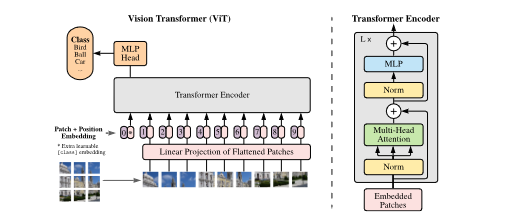

_Figure 1 from the ViT Paper. An image (mel spectrogram) goes where is an image, the image gets turned into patches and then projected to an embedding. The embedding then goes through the Transformer encoder and a classifier and the class is returned._

### 2.2 Exploring the Four Equations
The next main part(s) of the ViT paper we're going to look at are the following four equations.

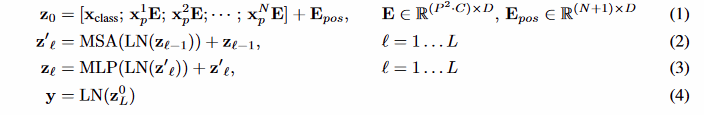

These four equations represent the math behind the major parts of the ViT architecture.


### 2.3 Exploring Table 1
Table 1 shows some hyperparameters for different ViT model variants. Let's focuse on the smallest version the ViT-Base model.

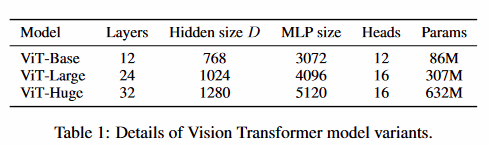

## 3. Equation 1: Split data into patches and creating the class position and patch embedding.


### 3.1 Calculating patch embedding input and output

- The image starts as 3D with size $H \times W \times C$. We are goint to generalize and then set $C=1$ since we are dealing with 2D arrays.
    - $(H, W)$ is the resolution of the original image (height, width).
    - $C$ is the number of channels.

- The image gets converted to a sequence of flattened 2D patches with size $N \times \left(P^{2} \cdot C \right)$.
    - $(P,P)$ is the resolution of each image patch (`patch_size=16`).
    - $N= H \cdot W / P^2$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

In [56]:
# Create example values
height = 64*FACTOR # H
width = 64*FACTOR # W
color_channels = 1 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N = H*W/P**2 = {number_of_patches}) with image height (H={height}), width (W={width}) and patch size (P={patch_size})")

Number of patches (N = H*W/P**2 = 256) with image height (H=256), width (W=256) and patch size (P=16)


- **Input:** The image starts as 2D with size $H \times W \times C$.
- **Output:** The image gets converted to a sequence of flattened 2D patches with size $N \times \left(P^2 \cdot C\right)$.

In [57]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (256, 256, 1)
Output shape (single 2D image flattened into patches): (256, 256)


### 3.2 Turning a single image into patches
We want to turn every image into patches of itself inline with Figure 1 of the ViT paper. Let's visualize what it looks like to turn an image into patches.

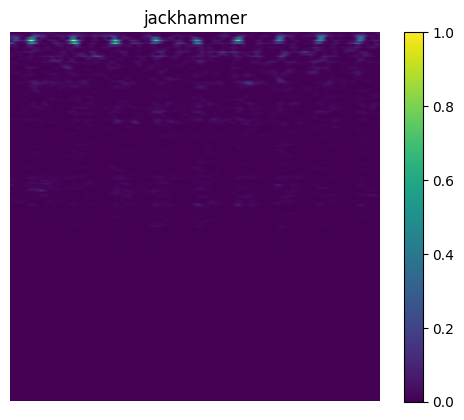

In [58]:
# View single image
batch, labels = next(iter(train_dataloader))

INDEX = 4
label = labels[INDEX]
image = batch[INDEX]
image_permuted = image.cpu().permute(1,2,0)
plt.imshow(image_permuted[0:,]) # adjust for matplotlib
plt.title(class_names[label])
plt.colorbar()
plt.axis(False);

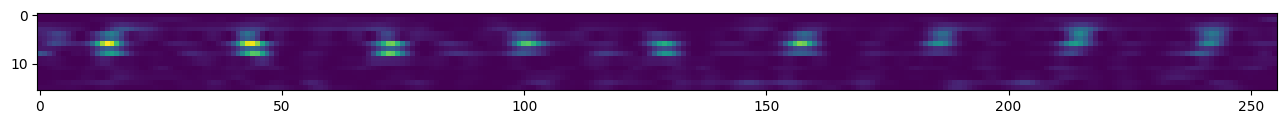

In [59]:
# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Now we've got the top row, let's turn it into patches. We can do this by iterating through the number of patches there would be in the top row.

Number of patches per row: 16
Patch size: 16 pixels x 16 pixels


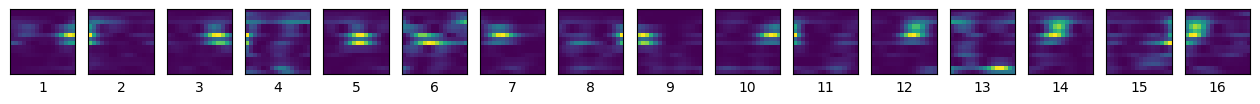

In [60]:
# Create a series of subplots
img_size = 64*FACTOR
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for col, patch in enumerate(range(0, img_size, patch_size)):
    axs[col].imshow(image[0][:patch_size, patch:patch+patch_size].cpu());
    axs[col].set_xlabel(col+1)
    axs[col].set_xticks([])
    axs[col].set_yticks([])

This time we'll iterate through the indexes for heigh and width and plot each patch as it's own subplot.

Number of patches per row: 16        
Number of patches per column: 16        
Total patches: 256        
Patch size: 16 pixels x 16 pixels


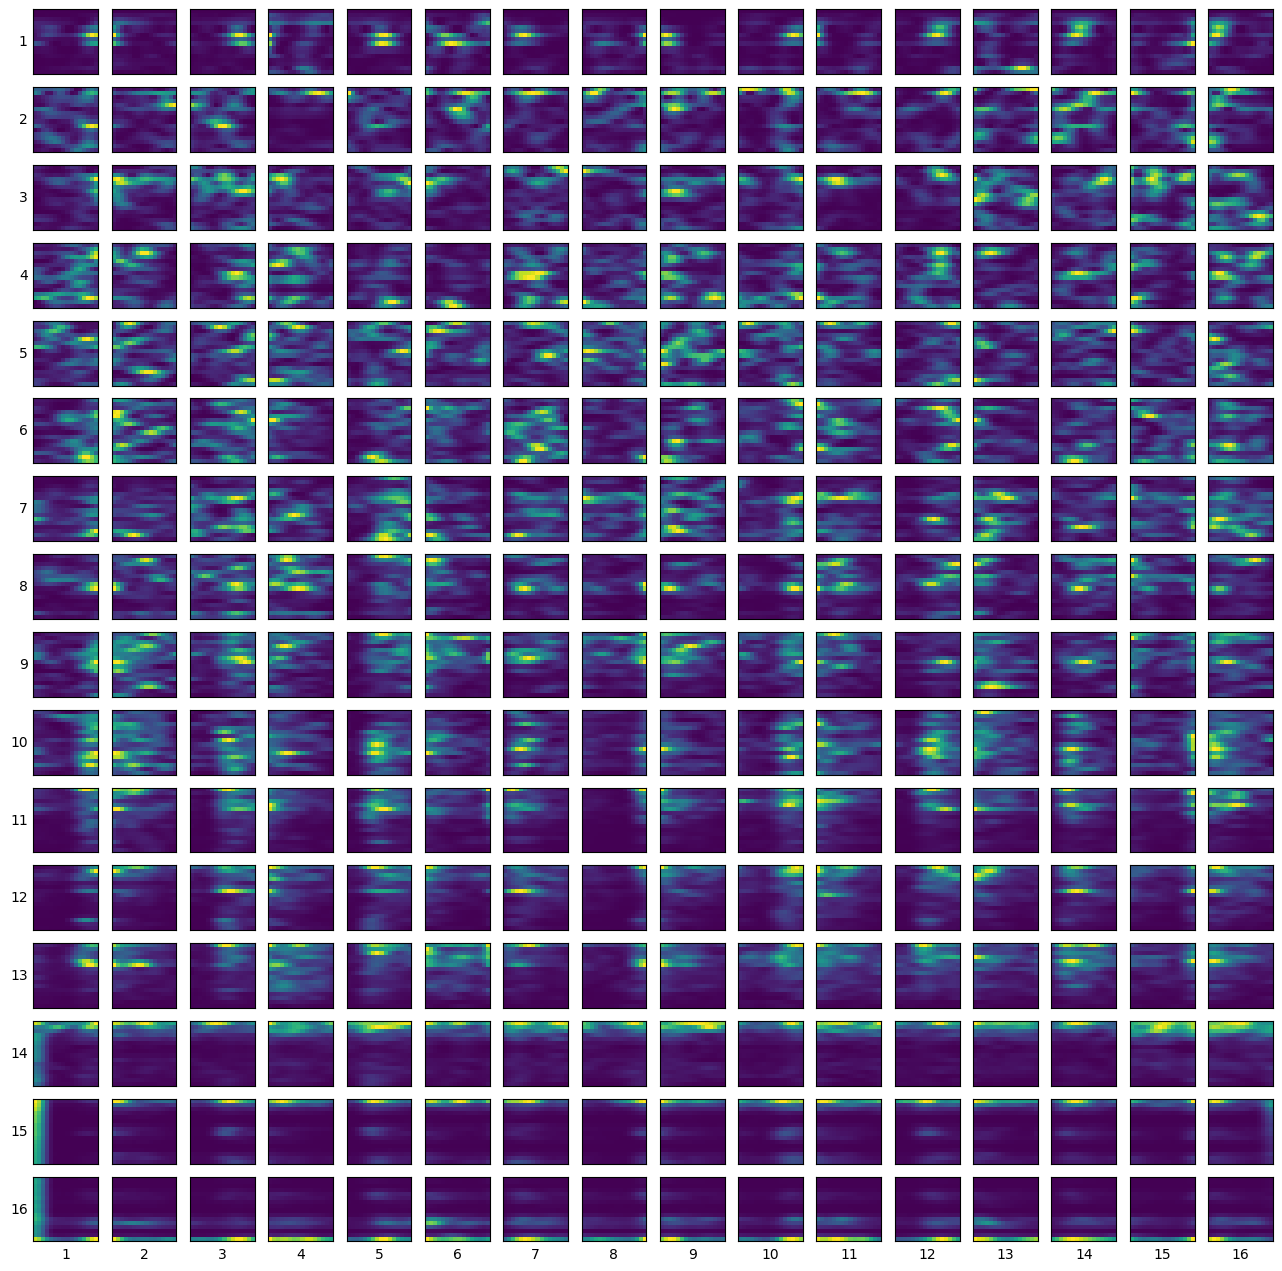

In [61]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 64*FACTOR
patch_size = 16
num_patches = img_size//patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for row, patch_height in enumerate(range(0, img_size, patch_size)):
    for col, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[row, col].imshow(image[0][patch_height:patch_height+patch_size, # iterate through height
                                      patch_width:patch_width+patch_size # iterate through width
                                      ].cpu());

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[row, col].set_ylabel(row+1,
                                 rotation='horizontal',
                                 horizontalalignment='right',
                                 verticalalignment='center')
        axs[row, col].set_xlabel(col+1)
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        axs[row, col].label_outer()


### 3.3 Creating image patches with `torch.nn.Conv2D()`
The authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN).

> **Hybrid Architecture**. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

The `torch.nn.Conv2D()` layer can be used to create patches from an image by setting the `kernel_size` and `stride` parameters equal to the `patch_size`. This will create a convolutional kernel that is the same size as a patch, and it will step through the image, creating a patch at each step.

The `torch.nn.Flatten()` layer can then be used to flatten the spatial dimensions of the patch, resulting in a vector that represents the patch. This vector can then be used as the input to a transformer model.

In summary, the following steps can be used to create patch embeddings with `torch.nn.Conv2D()` and `torch.nn.Flatten()`:

1. Create a `torch.nn.Conv2D()` layer with the following parameters:
    - `in_channels`: The number of channels in the image.
    - `out_channels`: The number of channels in the patch embedding.
    - `kernel_size`: The size of the patch.
    - `stride`: The stride of the convolutional kernel.

2. Pass the image to the `torch.nn.Conv2D()` layer.
3. Use the `torch.nn.Flatten()` layer to flatten the spatial dimensions of the output from the `torch.nn.Conv2D()` layer.
4. The output from the `torch.nn.Flatten()` layer is the patch embedding.

In [62]:
from torch import nn

# Set the patch size
patch_size=16
channels = 1

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=1, # number of color channels
                   out_channels=patch_size**2*channels, # D is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

Now that we have a convolutional layer, let's examine what occurs when we pass a single image through it.

In [63]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.cpu().unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 256, 16, 16])


When we pass our image through the convolutional layer, it is converted into a sequence of 256 feature maps (this is also known as the embedding size or $D$). The output shape can be interpreted as follows:

```python
torch.Size([1, 256, 4, 4]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps to see what they look like.


Showing random convolutional feature maps from indexes: [255, 142, 227, 233, 89]


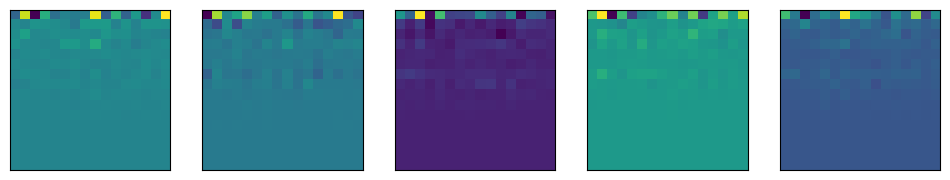

In [64]:
# Plot 5 random convolutional feature maps
import random
random_indexes = random.sample(range(0, 256), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

### 3.4 Flattening the patch embedding with `torch.nn.Flatten()`
The desired output shape of the patch embedding layer of the ViT model is a 1D sequence of flattened 2D patches. The current tensor shape is (batch, embedding_dim, feature_map_height, feature_map_width). We need to flatten the spatial dimensions of the feature map to get the desired output shape. We can use the `torch.nn.Flatten()` layer to do this, and we can use the start_dim and end_dim parameters to specify which dimensions to flatten.

In [65]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Great! Now let's summarize the steps involved:

1. Take a single image.
2. Pass it through a convolutional layer to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.


Original image shape: torch.Size([1, 256, 256])
Image feature map shape: torch.Size([1, 256, 16, 16])
Flattened image feature map shape: torch.Size([1, 256, 256])


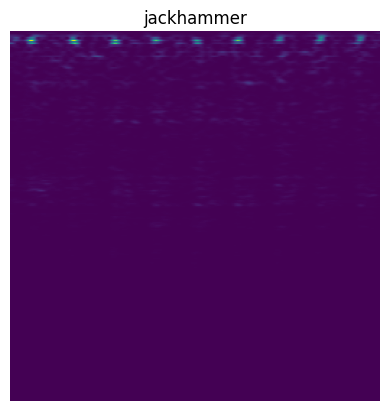

In [66]:
# 1. Take a single image
plt.imshow(image.cpu().squeeze(0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into 2D feature maps
image_out_of_conv = conv2d(image.cpu().unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the 2D feature map
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

The desired output shape is (16, 256), which means that there are 16 patches each with an embedding dimension of 256. The current shape is (1, 256, 16), which means that there is a batch size of 1 and each patch has an embedding dimension of 256. The only difference is the order of the dimensions.

We can rearrange the dimensions using the `torch.Tensor.permute()` function in the following section.

### 3.5 Create a PyTorch module for the ViT patch embedding layer

The patch embedding layer is a crucial component of the Vision Transformer (ViT) architecture. It is responsible for converting an image into a sequence of patches, which are then fed into the transformer encoder.

To create a PyTorch module for the patch embedding layer, we can follow these steps:

1. Create a class called `PatchEmbedding` that inherits from the `nn.Module` class.
2. Initialize the class with the parameters `in_channels=1`, `patch_size=16` (`patch_size` is for ViT-Base model from ViT paper), and `embedding_dim=256`.
3. Create a layer to turn an image into patches using the `nn.Conv2d()` function.
4. Create a layer to flatten the patch feature maps into a single dimension using the `nn.Flatten()` function.
5. Define a `forward()` method that takes an input image and passes it through the layers created in steps 3 and 4.
6. Make sure the output shape of the forward() method reflects the required output shape of the ViT architecture.

In [67]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 1.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 256.
    """
    # Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=1,
                 patch_size:int=16,
                 hidden_dim:int=256):
        super(PatchEmbedding, self).__init__()

        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=hidden_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2*C, N] -> [batch_size, N, P^2*C]

Let's try it out on a single image.

In [68]:
torch.manual_seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=1,
                          patch_size=16,
                          hidden_dim=256)

# Pass a single image through
print(f"Input image shape: {image.cpu().unsqueeze(0).shape}")
patch_embedded_image = patchify(image.cpu().unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 1, 256, 256])
Output patch embedding shape: torch.Size([1, 256, 256])


In summary, the **input** to the patch embedding layer is a 2D image with size $C \times H \times W $. The **output** of the patch embedding layer is a 1D sequence of flattened 2D patches with size $N \times\left(P^2 \cdot C\right)$.
Here is what each of the variables in the output shape represents:
- $H$ and $W$ are the resolution of the original image.
- $C$ is the number of channels.
- $P$ is the patch size.
- $N = H \cdot W / P^2$ is the number of patches. This is also the effective input sequence length for the Transformer.

We have now replicated the patch embedding for equation 1, but we have not yet added the class token or position embedding. We will do that later.

### 3.6 Applying Equation 1 using PyTorch Layers: creating the class token and position embeddings

We have now come a long way in terms of turning our input images into an embedding and replicating equation 1 from section 3.1 of the ViT paper:

$\mathbf{z}_0=\left[\mathbf{x}_{\text{class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text{pos }}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text{pos }} \in \mathbb{R}^{(N+1) \times D}$

Since $ \mathbf{x}_{p}^{i} \in \mathbb{R}^{N \times (P^2 \cdot C)} $ and $ \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C)} \times D $, the transformation to patch embeddings will be
$$ \mathbf{x}_{p}^{i}\mathbf{E} \in \mathbb{R}^{N \times D} $$

Now, let's put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can following the steps in the code to reproduce the class token and position embeddings.

In [69]:
torch.manual_seed(42)

# Set patch size
patch_size = 16
image = image.cpu()
# Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=1,
                                       patch_size=patch_size,
                                       hidden_dim=256)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# Create class token embedding of size shape (batch,1,D)
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([1, 256, 256])
Input image with batch dimension shape: torch.Size([1, 1, 256, 256])
Patching embedding shape: torch.Size([1, 256, 256])
Class token embedding shape: torch.Size([1, 1, 256])
Patch embedding with class token shape: torch.Size([1, 257, 256])
Patch and position embedding shape: torch.Size([1, 257, 256])


Creating the patch embedding is the most complex part of replicating the ViT paper in code. However, once we have created the patch embedding, we can use existing PyTorch layers to create the other parts of the model, such as the Multi-Head Attention and Norm layers.

## 4. Equation 2: Multi-Head Attention (MSA)

Our input data has been segmented into patches and embeddings. Now, let's proceed to the next phase of the ViT architecture. Equation 2, as a reminder, is defined as follows:

$$
\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L
$$

This equation denotes a configuration where a Multi-Head Attention (MSA) layer is enveloped within a LayerNorm (LN) layer, along with a residual connection where the layer's input is summed with its output. We will refer to equation 2 as the "MSA block".

### 4.1 The Layer Normalization (LN) Layer

In PyTorch, the `torch.nn.LayerNorm()` function can be used for this purpose. The key parameter of interest is normalized_shape, which can be customized to match the dimension size that requires normalization. In our specific case, this dimension corresponds to D or 256, which is consistent with the normalization requirements of the ViT-Base model.

### 4.2 The Multi-Head Self Attention (MSA) Layer

For the practical implementation of the Multi-Head Self Attention (MSA) layer in PyTorch, we can utilize the torch.nn.MultiheadAttention() module. This implementation requires specific parameters:

- **embed_dim**: The embedding dimension, drawn from Table 1's Hidden size (D).
- **num_heads**: The number of attention heads to utilize, as indicated in Table 1 (Heads).
- **dropout**: In case is applied to the attention layer. Dropout is not employed post qkv-projections, as outlined in Appendix B.1 of the ViT paper.
- **batch_first**: If the batch dimension comes first, "yes" in our case.

### 4.3 Applying Equation 2 using PyTorch Layers

Now, let's code what we've talked about with the LayerNorm (LN) and Multi-Head Attention (MSA) layers in equation 2.

To do this, we'll follow these steps:

1. Make a class called `MultiheadSelfAttentionBlock` that's based on `torch.nn.Module`.

2. Start the class with the settings we got from Table 1 in the ViT paper for the ViT-Base model.

3. Set up a layer normalization (LN) part using `torch.nn.LayerNorm()`, making sure the `normalized_shape` matches our embedding dimension ($D$) from Table 1.

4. Build a multi-head attention (MSA) part, setting things like `embed_dim`, `num_heads`, `dropout`, and `batch_first` as needed.

5. Create a `forward()` way in our class. It'll pass the inputs through both the LN layer and the MSA layer to do the work.

In [70]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim: int = 256, # Hidden size D
                 num_heads: int = 12, # Heads from Table 1 for ViT-Base
                 attn_dropout: float = 0.): # Paper does not employ dropout within the MSABlocks.
        super(MultiheadSelfAttentionBlock, self).__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

Using the same input tensor x as query, key, and value within the nn.MultiheadAttention layer allows the model to perform self-attention, which enables each position in the sequence to attend to other positions in the sequence, capturing relationships and dependencies in the data.

We have successfully implemented equation 2 in code (excluding the residual connection at the end, which we'll address later).

Moving forward to the next step!

## 5. Equation 3: Multilayer Perceptron (MLP)

In the field of machine learning, the term MLP, or multilayer perceptron, designates a specific form of artificial neural network architecture. Comprising multiple layers of interconnected nodes, this configuration empowers the network to effectively learn and discern intricate patterns present within data.

Let's now recreate equation 3:

$$
\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L
$$

Here, "MLP" stands for "multilayer perceptron," while "LN" represents "layer normalization," as explained earlier. The additional term at the equation is the term knowns as the skip or residual connection.
We'll call equation 3 the "MLP block" in the Transformer encoder.

In the context of the ViT paper, the structure of the MLP is defined in section 3.1:

 > The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers (`torch.nn.Linear()` in PyTorch) and `GELU non-linearity` is the Gaussian Error Linear Units, a non-linear activation function (`torch.nn.GELU()` in PyTorch).

> **Note**: A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". ViT paper even use all three terms to describe the same thing.

After every linear layer in the MLP block has a dropout layer (`torch.nn.Dropout()` in PyTorch)
The value of dropout can be found in Table 3 being `dropout=0.1`.

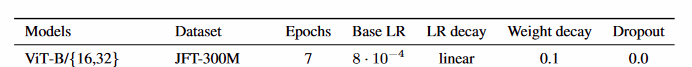

Hence, the structure of MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

### 5.1 Applying Equation 3 using PyTorch Layers

Using the numbers given in Table 1, we can set the settings for coding equation 3.

1. Make a class named `MLPBlock` that uses `torch.nn.Module`.
2. Initialize the class with hyperparameters we got from Tables 1 and 3 in the ViT paper for the ViT-Base model.
3. Set up a layer normalization (LN) part using `torch.nn.LayerNorm()`. The `normalized_shape` is the same as our embedding dimension ($D$ from Table 1).
4. Create a series of steps for the MLP layers using `torch.nn.Linear()`, `torch.nn.Dropout()`, and `torch.nn.GELU()` with the right numbers from Tables 1 and 3.
5. Make a `forward()` way in our group. It'll process the input through the LN part and the MLP steps.

In [71]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    def __init__(self,
                 embedding_dim: int = 256, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
                 dropout: float = 0.1): # Dropout from Table 3 for ViT-Base
        super(MLPBlock, self).__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Observe that the size of our data remains unchanged as it enters and exits the MLP block.

Nevertheless, the size does alter while the data moves through the `nn.Linear()` layers inside the MLP block. It expands to the MLP size specified in Table 1 and then returns to the hidden dimension $D$ mentioned in Table 1.

We've duplicated Equation 3 (excluding the residual connection at the end).

With both Equation 2 and 3 now translated into PyTorch code, the next step is to combine them to build the Transformer Encoder.

## 6. Equation 4: Developing the Transformer Encoder

In the world of deep learning, when we talk about an "encoder" or "auto encoder," we're referring to a number of layers that work together to change an input (like an image) into a set of numbers.

In our situation, this Transformer Encoder will take our patched image and turn them into a special learned way using different layers of MSA blocks and MLP blocks. This is based on section 3.1 of the ViT Paper:

> "The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019)".

We've created MSA and MLP sections, but what should we do with the residual connections?

Residual connections work by adding the input of one layer to the output of another layer. For the ViT design, the residual connection means we add the starting input of the MSA block to its output before it goes to the MLP block. The same thing happens with the MLP block before it moves to the next Transformer Encoder block.


### 6.1 Constructing a Transformer Encoder by Combining Our Custom Layers

Let's build a ViT Transformer Encoder using PyTorch. This involves merging the layers we've created earlier.


In [72]:
# 1. Create a class
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize with hyperparameters from Tables 1 and 3
    def __init__(self,
                 embedding_dim: int = 256, # Hidden size D from Table 1 for ViT-Base
                 num_heads: int = 12, # Heads from Table 1 for ViT-Base
                 mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout: float = 0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout: float = 0): # Amount of dropout for attention layers
        super(TransformerEncoderBlock, self).__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In ViT-Base, we'll assemble 12 of these Transformer Encoder blocks together, creating the main structure of our design.

> **Note**: There is a pre-existing `torch.nn.TransformerEncoderLayer` available in PyTorch. However, in order to gain hands-on experience, we will not be using this PyTorch layer. Instead, we will implement our own Transformer Encoder layer.

### 6.2 Equation 4: MLP Head

We now turn our attention to addressing another significant equation, namely equation 4:
$$
\mathbf{y} = \operatorname{LN}(\mathbf{z}_L^0)
$$
In this context, $\mathbf{z}_L^0$ pertains to the output of the 0th index token from $L$-th MLP block. To classify the data into the number of classes within our dataset, we apply the following:

```python
y = nn.Linear(nn.LayerNorm(x_output_MLP_block[:,0]))
```

This combination effectively transforms the logit outputs of the Transformer Encoder, specifically the 0th index ($\mathbf{z}_L^0$), into a form that aligns with the number of target classes in our dataset.

## 7. Bringing Everything Together to Build ViT

We're at the point where we'll combine all the components we've developed to recreate the complete ViT architecture.

Starting from the image patches and positional embeddings to the Transformer Encoders and the MLP Head.

In order to construct the comprehensive architecture, we'll also need to stack multiple TransformerEncoderBlocks on top of each other. This can be accomplished by assembling them in a list and then passing that list to the `torch.nn.Sequential()` function.

Our focus will primarily be on the ViT-Base configuration outlined in Table 1. However, it's important to note that our code can be modified to suit other variations of the ViT model.


In [73]:
class ViT(nn.Module):
    """
    Creates a ViT Base architecture from
    `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
    <https://arxiv.org/abs/2010.11929>`.

    Args:
        img_size (int): Input image resolution.
        patch_size (int): Patch size.
        in_channels (int): Number of channels in the input image.
        num_layers (int): Number of layers (blocks) in the architecture.
        num_heads (int): Number of attention heads in the multi-head self-attention mechanism.
        hidden_dim (int): Hidden dimension size for the model.
        mlp_dim (int): Dimension size of the Multi-Layer Perceptron (MLP) layers.
        mlp_dropout (float): Dropout probability for the MLP layers.
        embedding_dropout (float): Dropout probability for patch and position embeddings.
        num_classes (int): Number of classes for classification.

    Returns:
        torch.Tensor: Classification logits for input `x`.

    """
    def __init__(self,
                 img_size:int = 64, # Imput image resolution
                 patch_size:int = 16, # Patch size
                 in_channels:int = 1, # Number of channels in input image
                 num_layers:int = 12, # Layers from Table 1 for ViT-Base
                 num_heads:int = 8, # Heads from Table 1 for ViT-Base
                 hidden_dim:int = 256, # Hidden size D from Table 1 for ViT-Base
                 mlp_dim:int = 3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float = 0.1, # Dropout for MLP layers
                 embedding_dropout:float = 0., # Dropout for patch and position embeddings
                 num_classes:int = 10): #
        super(ViT, self).__init__()

        # Verify that the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, hidden_dim),
                                            requires_grad=True)

        # Create position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, hidden_dim),
                                               requires_grad=True)

        # Create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              hidden_dim=hidden_dim)

        # Create TransformerEncoder blocks (employing nn.Sequential() to stack blocks)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=hidden_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_dim,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_layers)])

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=hidden_dim, eps=1e-6),
            nn.Linear(in_features=hidden_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Add position embedding to patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) + self.position_embedding

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass x through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # torch.Size([1, 256])

        return x

### 7.1 Creating and Evaluating a ViT Model

Here we specify the model's architecture with parameters such as input image size, patch size, number of layers, number of heads, hidden dimensions, and dropout rates for various components.

In [74]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 1, 64*FACTOR, 64*FACTOR) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (10 classes)
vit = ViT(img_size = 64*FACTOR, # Imput image resolution
          patch_size = 16, # Patch size
          in_channels = 1, # Number of channels in input image
          num_layers = 12, # Layers from Table 1 for ViT-Base
          num_heads = 8, # Heads from Table 1 for ViT-Base
          hidden_dim = 256, # Hidden size D from Table 1 for ViT-Base
          mlp_dim = 3072, # MLP size from Table 1 for ViT-Base
          mlp_dropout = 0.1, # Dropout for MLP layers
          embedding_dropout = 0., # Dropout for patch and position embeddings
          num_classes = len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor).shape

torch.Size([1, 10])

The output shape is equal to the number of classes. Additionally, the `ViT` class can be customized with parameters such as `img_size`, `patch_size`, `num_classes`, and `num_layers`, providing the flexibility to make modifications as needed.

### 7.2 Create a summary of ViT model

To generate a comprehensive summary of the ViT model, you can utilize the `torchinfo.summary()` function, which provides a visual overview of the model's architecture and details.

In [75]:
try:
    import torchinfo
except:
    !pip install torchinfo

In [76]:
# In case you encounter the error `NotImplementedError: A UTF-8 locale is required.`
# You can fix it by running this cell:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [77]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 1, 64*FACTOR, 64*FACTOR), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 1, 256, 256]    [32, 10]             66,048               True
├─PatchEmbedding (patch_embedding)                           [32, 1, 256, 256]    [32, 256, 256]       --                   True
│    └─Conv2d (patcher)                                      [32, 1, 256, 256]    [32, 256, 16, 16]    65,792               True
│    └─Flatten (flatten)                                     [32, 256, 16, 16]    [32, 256, 256]       --                   --
├─Dropout (embedding_dropout)                                [32, 257, 256]       [32, 257, 256]       --                   --
├─Sequential (transformer_encoder)                           [32, 257, 256]       [32, 257, 256]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 257, 256]       [32, 257, 256]

## 8. Training the Vision Transformer (ViT) model

We can import the train() function from the engine.py module, which is available on my GitHub repository. This repository contains functions for training, plotting training curves, and saving models.

To download the torch_modules library, run the following command:

In [78]:
!git clone https://github.com/adinmg/PyTorch_Utils.git

fatal: destination path 'PyTorch_Utils' already exists and is not an empty directory.


In the ViT paper they mentioned that during the training and fine-tuning process, all models, "are trained using the Adam optimizer with parameters $\beta_1=0.9$ and $\beta_2=0.999$". The training employs a batch size of 4096 and incorporates a high weight decay of 0.1". The learning rate will be set to 0.003 as per Table 3.

We will reduce the batch size to 64 value in order to fit the model in our machine.

In [79]:
# After training with this hyperparameters is no
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)

The ViT paper does not explicitly specify a particular loss function. However, since our task involces multi-class classification, which is also the case in the ViT paper, we will use the `torch.nn.CrossEntropyLoss()` function.

In [80]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
from PyTorch_Utils import engine
from PyTorch_Utils.helper_functions import set_seeds

# Set the seeds
set_seeds(seed=42)

# Training function (engine.py)
vit_results = engine.train(model=vit.to(device),
                           train_dataloader=train_dataloader,
                           validate_dataloader=valid_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3434 | train_acc: 0.1161 | test_loss: 2.2828 | test_acc: 0.0990
Epoch: 2 | train_loss: 2.0936 | train_acc: 0.2076 | test_loss: 1.9332 | test_acc: 0.2864
Epoch: 3 | train_loss: 1.8215 | train_acc: 0.3292 | test_loss: 1.7647 | test_acc: 0.3492
Epoch: 4 | train_loss: 1.7142 | train_acc: 0.3755 | test_loss: 1.6559 | test_acc: 0.3888
Epoch: 5 | train_loss: 1.6510 | train_acc: 0.3958 | test_loss: 1.6523 | test_acc: 0.4170
Epoch: 6 | train_loss: 1.6131 | train_acc: 0.4153 | test_loss: 1.5500 | test_acc: 0.4408
Epoch: 7 | train_loss: 1.5440 | train_acc: 0.4424 | test_loss: 1.5636 | test_acc: 0.4328
Epoch: 8 | train_loss: 1.5407 | train_acc: 0.4449 | test_loss: 1.4969 | test_acc: 0.4531
Epoch: 9 | train_loss: 1.5343 | train_acc: 0.4523 | test_loss: 1.5186 | test_acc: 0.4613
Epoch: 10 | train_loss: 1.5191 | train_acc: 0.4546 | test_loss: 1.4916 | test_acc: 0.4599


A good comparison for our model's performance is the link: https://www.section.io/engineering-education/machine-learning-for-audio-classification/, which uses a series of dense layers to classify urban sounds by extracting features using Mel-Frequency Cepstral Coefficients. This model achieves a test accuracy of 78%.

We will conduct a short series of experiments to improve the performance of our model, following this table:

Table 1. Experiments

| weigh decay | image size | Test loss | Test accuracy |
| - | :-: | -: | -----: |
| 0.1 | 64x64 | - | - |
| 0 | 64x64 | - | - |
| 0 | 128x128 | - | - |
| 0 | 256x256 | - | - |

### 8.1 Loss curves

To check out our ViT model's loss curves, we can use the `plot_loss_curves()` function from the `helper_functions.py` module, which we have downloaded.

In [ ]:
from PyTorch_Utils.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# Save results in a csv file
pd.DataFrame(vit_results).to_csv('01_vit_image_size_64_weigh_0.csv')

## 9. Inspecting ViT loss curves for the experiments

Previously, we saved a series of CSV files with the experiments shown in Table 1. These files contain the training and validation losses for each experiment. We can use these files to inspec the loss curves for each experiment and se how the model's performance changes over epochs.

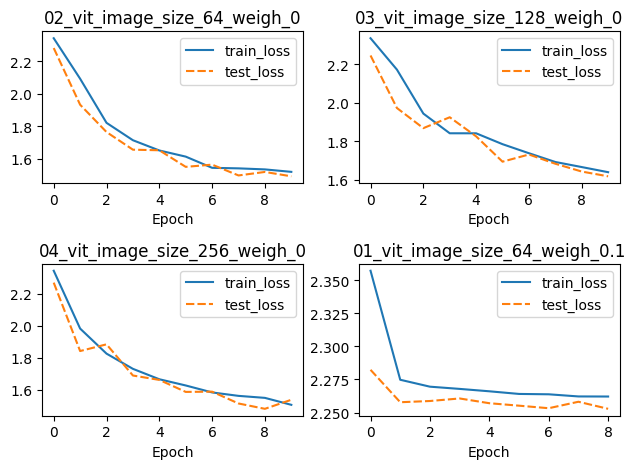

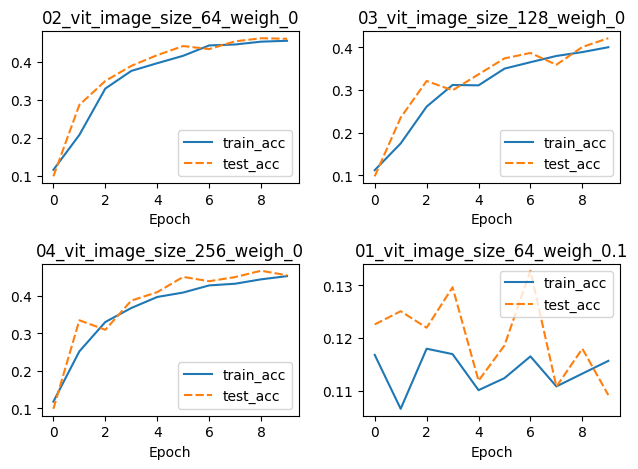

In [ ]:
import glob

def plot_summary(csv_files:glob.glob, metric:list[str]):

    assert 'loss' in metric or 'acc' in metric, 'The metric must be either "loss" or "acc"'
    # if not 'loss' in metric or not 'acc' in metric:
    #   print('The metric must be either "loss" or "acc"')

    fig, axs = plt.subplots(2,2)
    for i in range(0,4):
        row = i // 2
        col = i % 2

        sns.lineplot(pd.read_csv(csv_files[i], usecols=['train_'+metric, 'test_'+metric]), ax=axs[row,col])
        axs[row, col].set_title(csv_files[i][:-4])
        axs[row, col].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()


csv_files = glob.glob('*.csv')
plot_summary(csv_files, 'loss')

plot_summary(csv_files, 'acc')


| Experiment | weigh decay | image size | Test loss | Test accuracy |
| - | :-: | :-: | -: | -: |
| 1 | 0.1 | 64x64 | nan | 0.1091 |
| 2 | 0 | 64x64 | 1.4916 | 0.4599 |
| 3 | 0 | 128x128 | 1.6180 | 0.4211 |
| 4 | 0 | 256x256 | 1.5387 | 0.4541 |


Based on the results of the experiments, experiments 2 (image size of 64x64 and weight loss of 0) and 4 (image size of 256x256 and weight loss of 0) are the most suitable to train for more epochs.

Notice that we set the weight decay parameter to 0.1, the model didn't learn.

Experiment 2 achieved a test accuracy of 45.9%, while experiment 4 achieved a test accuracy of 45.4%. It is known that increasing the image size from 64x64 to 256x256 can improve the performance of the model. However, experiment 4 is more computationally expensive than experiment 2. Therefore, we will train experiment 4 for up to 30 epochs to see if we can further improve the performance of the model.

In the next part, we will do transfer learning to compare with. Pretrained ViT models accept images of 256x256, so we will use the model trained in experiment 4 to make a fair comparison using transfer learning.


### 9.1 Training for more epoch
It is known that training for more epoch is a solution to increase model performance. In this subsection we'll train model from experiment 4 up to 30 epoch to see if there is an increase in the accuracy of the model.

In [81]:
from PyTorch_Utils import engine
from PyTorch_Utils.helper_functions import set_seeds

# Set the seeds
set_seeds()

# After training with this hyperparameters is no
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training function (engine.py)
vit_results = engine.train(model=vit.to(device),
                           train_dataloader=train_dataloader,
                           validate_dataloader=valid_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=30,
                           device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3429 | train_acc: 0.1182 | valid_loss: 2.2686 | valid_acc: 0.0990
Epoch: 2 | train_loss: 2.0042 | train_acc: 0.2442 | valid_loss: 1.8716 | valid_acc: 0.2959
Epoch: 3 | train_loss: 1.8369 | train_acc: 0.3197 | valid_loss: 1.8041 | valid_acc: 0.3649
Epoch: 4 | train_loss: 1.7523 | train_acc: 0.3674 | valid_loss: 1.6663 | valid_acc: 0.4018
Epoch: 5 | train_loss: 1.6811 | train_acc: 0.3898 | valid_loss: 1.6508 | valid_acc: 0.4406
Epoch: 6 | train_loss: 1.6190 | train_acc: 0.4180 | valid_loss: 1.5610 | valid_acc: 0.4547
Epoch: 7 | train_loss: 1.5743 | train_acc: 0.4365 | valid_loss: 1.5312 | valid_acc: 0.4728
Epoch: 8 | train_loss: 1.5557 | train_acc: 0.4468 | valid_loss: 1.5380 | valid_acc: 0.4331
Epoch: 9 | train_loss: 1.5622 | train_acc: 0.4400 | valid_loss: 1.4974 | valid_acc: 0.4871
Epoch: 10 | train_loss: 1.5300 | train_acc: 0.4489 | valid_loss: 1.5026 | valid_acc: 0.4770
Epoch: 11 | train_loss: 1.5369 | train_acc: 0.4562 | valid_loss: 1.4516 | valid_acc: 0.49

After training for 30 epochs, the model's accuracy has reached a plateau. This suggests that the model has converged and is no longer learning. One way to overcome this is to employ transfer learning.

Transfer learning is a machine learning technique where a model that has been trained on a large dataset is used as a starting point for training a new model on a smaller dataset. The pre-trained model can be used to learn the general features of the data, which can then be fine-tuned on the smaller dataset. This can help to improve the accuracy of the new model, even if the smaller dataset is not as large as the original dataset.

In the next section, we will make use of transfer learning to improve our previous results. We will use a pretrained ViT model from `torchvision.models`. We will then fine-tune this model on our smaller dataset of audio data. We expect that this will improve the model's accuracy for classifying audio.


## 10. Transfer Learning from pretrained ViT model

We will get the pretrained ViT-Base with patch size 16 from the `torchvision.models` library and prepare it for our `UrbanSoundDataset` use case by turning it into a feature extractor transfer learning model.

In [ ]:
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PyTorch_Utils.helper_functions import set_seeds

def create_vit_model(num_classes):
  pretrained_vit_weights = ViT_B_16_Weights.DEFAULT
  model = vit_b_16(weights=pretrained_vit_weights).to(device)

  # Freeze every parameter
  for parameter in model.parameters():
    parameter.requires_grad = False

  set_seeds()
  model.heads = nn.Linear(in_features=768, out_features=num_classes).to(device)
  return model, pretrained_vit_weights.transforms

vit_pretrained, pretrained_vit_transforms = create_vit_model(num_classes=len(class_names))

In [ ]:
from torchinfo import summary

summary(model=vit_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.1 Preparing 2D Mel Spectrograms as 3D for `torchvision.models.vit_b_16`

In order to perform transfer learning, it is important to transform our mel spectrograms into 3D arrays by creating our own class `MyTransformation`. This class will perform the following steps:

1. Create mel spectrograms.

2. Normalize the mel spectrograms so that the maximum value is 255.

3. Repeat the same channel 1 to channels 2 and 3.

4. Transform the mel spectrograms into the format that the `torchvision.models.vit_b_16` model requires.

Since we are normalizing for a 3D array, we need to set the `normalize` argument to `False` in the `UrbanSoundDataset` class. This will prevent the dataset from normalizing the mel spectrograms again.

In [ ]:
from torchvision.transforms import Compose
import torch.nn as nn

AUDIO_DIR = "./data"
SAMPLE_RATE = 22050*FACTOR
NUM_SAMPLES = 22050*FACTOR

# Instantiate pretrained ViT transforms
vit_transforms = pretrained_vit_transforms()

# Wrap the normalize function in a torch.nn.Module
class MyTransformations(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, tensor):
    tensor = mel_spectrogram(tensor)
    tensor = tensor * 255 / tensor.max()
    tensor = torch.repeat_interleave(tensor, repeats=3, dim=0)
    tensor = vit_transforms(tensor)
    return tensor

mytransformations = MyTransformations()

In [ ]:
# Create train/test dataloader and get class names as a list
BATCH_SIZE = 64

train_dataloader, valid_dataloader, class_names = create_dataloaders(df_train=df_train,
                                                                     df_valid=df_valid,
                                                                     transformation=mytransformations.to(device),
                                                                     batch_size=BATCH_SIZE)

### 10.2 Perform Transfer Learning

In [ ]:
from PyTorch_Utils import engine
from helper_functions import set_seeds

optimizer = torch.optim.Adam(params=vit_pretrained.parameters(), lr=1e-4)

loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds(seed=42)

# Training function from engine module
vit_results = engine.train(model=vit_pretrained.to(device),
                           train_dataloader=train_dataloader,
                           validate_dataloader=valid_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

## 11. Saving the model

To save the model, we will use the `save_model` function from the `utils.py` module. This function takes the model as input and saves it to a file.

In [ ]:
from PyTorch_Utils import utils

# Save the model with help from utils.py
utils.save_model(model=vit_pretrained,
                 target_dir="models",
                 model_name="01_vit_size256_epoch_10.pth")

[INFO] Saving model to: models/01_vit_size256_epoch_10.pth


## 12. Testing our pretrained ViT Model


In [ ]:
import torch

vit_pretrained = create_vit_model(num_classes=len(class_names))

vit_pretrained.load_state_dict(torch.load('01_vit_size256_epoch_10.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm

def predict_and_store(dataset: torch.utils.data.Dataset,
                      model: torch.nn.Module,
                      class_names: List[str],
                      device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # Create an empty list to store prediction dictionaires
    pred_list = []

    # Loop through target paths
    for X, y in tqdm(dataset):
      X, y = X.to(device), y.to(device)

      # Create empty dictionary to store prediction information for each sample
      pred_dict = {}

      # Get the ground truth class name
      class_name = class_names[y]
      pred_dict["class_name"] = class_name

      # Start the prediction timer
      start_time = timer()

      # Add batch dimension and put image on target device
      X = X.unsqueeze(0)

      # Prepare model for inference by sending it to target device and turning on eval() mode
      model.to(device)
      model.eval()

      # Get prediction probability, predicition label and prediction class
      with torch.inference_mode():
          pred_logit = model(X) # perform inference on target sample
          pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
          pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
          pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

          # Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
          pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
          pred_dict["pred_class"] = pred_class

          # End the timer and calculate time per pred
          end_time = timer()
          pred_dict["time_for_pred"] = round(end_time-start_time, 4)

      # Does the pred match the true label?
      pred_dict["correct"] = class_name == pred_class

      # Add the dictionary to the list of preds
      pred_list.append(pred_dict)

    # Return list of prediction dictionaries
    return pred_list

### 12.1 Evaluating on Test Data


In [ ]:
# Create testing datasets
test_data = UrbanSoundDataset(annotations_df=df_test,
                              audio_dir=AUDIO_DIR,
                              transformation=mytransformations.to(device),
                              target_sample_rate= SAMPLE_RATE,
                              num_samples=NUM_SAMPLES,
                              device=device)

class_names_test = test_data.classes()

In [ ]:
from PyTorch_Utils.helper_functions import predict_and_store

vit_test_pred = predict_and_store(dataset=test_data,
                                  model=vit_pretrained,
                                  class_names=class_names_test,
                                  device='cuda')

In [ ]:
import pandas as pd

df_vit_test = pd.DataFrame(vit_test_pred)
df_vit_test.sample(10)

,class_name,pred_prob,pred_class,time_for_pred,correct
201,drilling,0.6496,street_music,0.7232,False
141,children_playing,0.2485,engine_idling,0.6984,False
790,air_conditioner,0.3179,jackhammer,0.7352,False
253,children_playing,0.4263,children_playing,1.0905,True
128,engine_idling,0.6315,engine_idling,0.7300,True
668,drilling,0.8051,drilling,1.1251,True
804,air_conditioner,0.6725,air_conditioner,0.7412,True
111,jackhammer,0.4506,jackhammer,0.9402,True
722,dog_bark,0.9254,dog_bark,0.7571,True
860,dog_bark,0.4903,dog_bark,0.8189,True


In [ ]:
df_vit_test.correct.sum()/len(df_vit_test)

0.6762013729977117

We obtained an accuracy of 67%, which is a good result considering that we did not tune any other hyperparameters than epochs.

### 12.1 Analyzing Predictions

Once the model has been trained, it can be used to make predictions on new data. The predictions can be analyzed to assess the performance of the model.

One way to analyze predictions is to look at the confusion matrix. The confusion matrix is a table that shows the true labels and the predicted labels for a set of data. The confusion matrix can be used to identify the classes that are being misclassified the most.


In [ ]:
# Create a DataFrame that contains the number of correct and incorrect predictions for each class in the test set.
df_count = pd.concat([df_vit_test.groupby('class_name')['correct'].sum().reset_index(),
                      df_vit_test.groupby('class_name')['correct'].apply(lambda x: (~x).sum()).reset_index()['correct'].rename('false')], axis=1)

In [ ]:
# Compute the accuracy per class and sort by it accuracy
df_count['total'] = df_count['correct'] + df_count['false']
df_count['accuracy'] = df_count['correct'] / df_count['total']
df_count.sort_values(by='accuracy')

,class_name,correct,false,total,accuracy
1,car_horn,18,28,46,0.391304
0,air_conditioner,44,64,108,0.407407
2,children_playing,57,39,96,0.593750
5,engine_idling,59,30,89,0.662921
9,street_music,84,31,115,0.730435
3,dog_bark,78,25,103,0.757282
4,drilling,83,26,109,0.761468
8,siren,53,16,69,0.768116
7,jackhammer,81,20,101,0.801980
6,gun_shot,34,4,38,0.894737


The results show that the pretrained ViT model with an image size of 256x256 has the highest accuracy for the gun shot class (89.4%), followed by jackhammer (80.1%), and siren (76.8%). The model has the lowest accuracy for the car horn class (39.1%) and air conditioner class (40.74%).

These results suggest that the model is better at classifying sounds that have distinct and easily identifiable features, such as gunshots and jackhammers. However, the model has more difficulty classifying sounds that have more subtle or overlapping features, such as car horns and air conditioners.

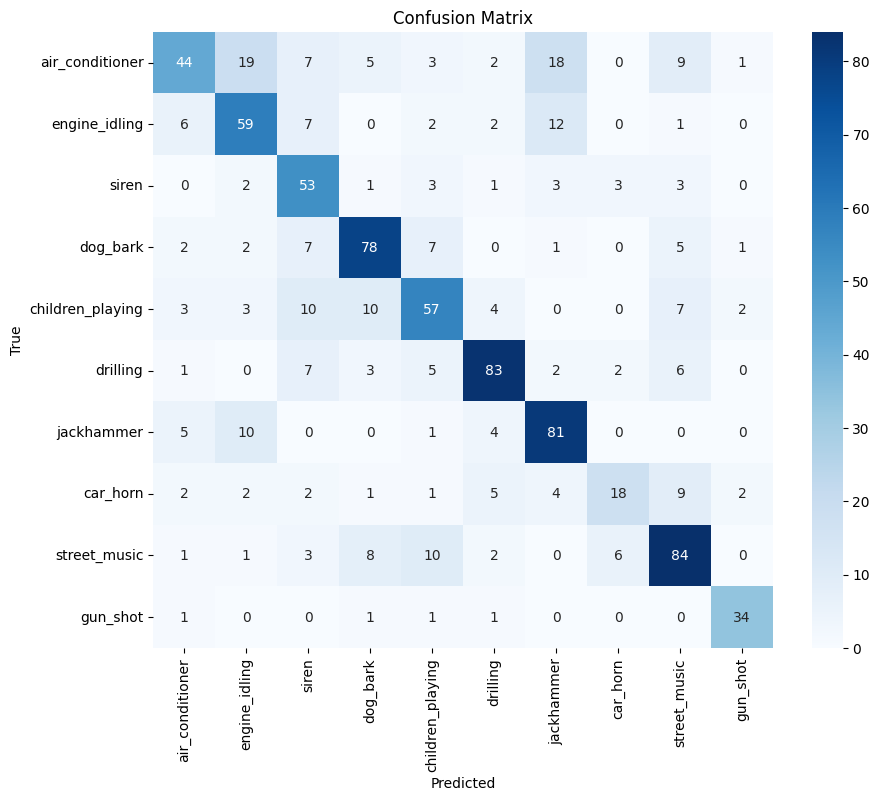

In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(df_vit_test['class_name'], df_vit_test['pred_class'], labels=df_vit_test['class_name'].unique())

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=df_vit_test['class_name'].unique(), yticklabels=df_vit_test['class_name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix can be used to identify the classes that are being misclassified the most. In this case, the classes that are being misclassified the most are:

- **Air conditioner** is misclassified as **engine idling** and **jackhammer**. This is likely due to the presence of certain frequency patterns that are common to these classes.

- **Engine idling** is misclassified as **jackhammer**. This suggests that the model may be struggling to distinguish between these two types of sounds, which share similarities in sound frequencies.

- **Car horn** is a class that has one of the lowest number of instances, and the model also easily confuses it with all of the rest of the classes, but mainly with **street music**. This is probably because car horns have a lot of noise that shares characteristics with music in the street.



# Takeaways

The following are some key takeaways from this project:

- **We successfully replicated the ViT architecture and applied it to a 2D, and a pretrained ViT architecture to a 3D array, achieving good results**. This suggests that the ViT architecture is a good approach for classifying audio data.

- **Converting mel spectrograms to grayscale images can lead to underperformance in transfer learning**. This is because transfer learning models are typically trained on color images, and the features that they learn are optimized for color images. When these models are applied to grayscale images, they may not be able to learn the same features, which can lead to a decrease in performance. As shown in the Results section of the following blog  the performance of transfer learning models on grayscale images is typically lower than on color images. https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a.

- **The UrbanSound8K dataset is a challenging dataset for array-like models**. This is because the dataset contains a wide variety of sounds, and the acoustic features of these sounds can be subtle and difficult to distinguish when they are represented by Mel Spectrograms. As a result, it can be difficult for array-like models to learn to classify the sounds in this dataset accurately.


The next steps for this project could include:

- **Tuning the hyperparameters**: The hyperparameters of the model can be tuned to improve the accuracy of the model. This can be a time-consuming and challenging process, but it can be worth the effort if it leads to a significant improvement in accuracy.

- **Changing the model**: The model can be changed to a different architecture. Adapting a transformer-based model to analyze MFCCs could lead to better results, reduce model size, and make training faster.

- **Improving the training data**: The training data can be improved by adding more data, or by augmenting the existing data. Adding more data can help the model to learn more about the different classes.Augmenting the data can help the model to learn to generalize to new data.

The specific steps that are taken will depend on the specific goals of the project. For example, if the goal is to achieve the highest possible accuracy, then tuning the hyperparameters may be the best option. However, if the goal is to develop a model that is fast and efficient, then changing the model may be a better option.




> I hope you have enjoyed 😊 reading this project
>
> If you have any feedback just let me know.
